# 0 - Chargement des données du lab: Introduction et Setup

Avant de commencer ce deuxième lab, nous devons charger les informations importantes vues lors du premier et second lab.

In [1]:
# importing necessary libraries
import os
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K

import sys
import h5py
import numpy as np
import random
import math
import gc
import importlib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt

# set a random seed for reproducibility (running with the given numbers should lead to the same results)
seed = 1502117258716530292 #random.randrange(sys.maxsize)
random.seed(seed)
# print('seed random was', seed)
seed = 4188638569 #random.randrange(2**32 - 1)
np.random.seed(seed)

AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

# Source : https://github.com/ANSSI-FR/ASCAD
def load_ascad(ascad_database_file, load_metadata=False, target_byte=2):
	check_file_exists(ascad_database_file)
	# Open the ASCAD database HDF5 for reading
	try:
		in_file	 = h5py.File(ascad_database_file, "r")
	except:
		print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
		sys.exit(-1)
	# Load profiling traces
	X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
	# Load profiling labels
	Y_profiling = np.array(in_file['Profiling_traces/labels'])
	# Load attacking traces
	X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
	# Load attacking labels
	Y_attack = np.array(in_file['Attack_traces/labels'])
	if load_metadata == False:
		return (X_profiling, Y_profiling), (X_attack, Y_attack)
	else:
		return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])


def check_file_exists(file_path):
    if os.path.exists(file_path) == False:
        print("Error: provided file path '%s' does not exist!" % file_path)
        sys.exit(-1)
    return

# ID means the label values are taken directly
# For HW leakage model, we show how the conversion is done
def calculate_HW(data):
    hw = [bin(x).count("1") for x in range(256)]
    return [hw[int(s)] for s in data]

# Functions for returning GE vector for increasing number of traces
def score_keys_convergence(predictions, plaintexts):
  """
  Computes the scores for each key hypothesis
  """
  scores_keys = np.zeros((256, predictions.shape[0]))
  for k in range(256):
    # Generate Hypothetical labels for a key-candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    for i in range(predictions.shape[0]):
      scores_keys[k, i] = scores_keys[k,i-1] + predictions[i, hypothetical_labels[i]]
  return scores_keys

def guessing_entropy_convergence(predictions, plaintexts, correct_key, nb_traces, nb_attacks=100):
  ranks = np.zeros((nb_attacks, nb_traces))
  # Take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):
    # Take random subset of traces
    r = np.random.choice(
            range(predictions_log.shape[0]), nb_traces, replace=False)

    key_scores = score_keys_convergence(predictions_log[r], plaintexts[r])

    for n in range(nb_traces):
      order_keys = np.argsort(key_scores[:, n])[::-1]
      ranks[attack, n]  = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks, axis=0), np.average(ranks, axis=0)

# Functions to calculate GE for a given number of attack traces
def score_keys(predictions, plaintexts):
  """
  Computes the scores for each key hypothesis
  """
  scores_keys = np.zeros(256)
  for k in range(256):
    #Generate Hypothetical labels for a key-candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    for i in range(predictions.shape[0]):
      scores_keys[k] += predictions[i, hypothetical_labels[i]]
  return scores_keys

def guessing_entropy(predictions, plaintexts, correct_key, nb_traces, nb_attacks=100):
  ranks = np.zeros(nb_attacks)
  # Take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):
    # Take random subset of traces
    r = np.random.choice(
            range(predictions_log.shape[0]), nb_traces, replace=False)

    key_scores = score_keys(predictions_log[r], plaintexts[r])

    order_keys = np.argsort(key_scores)[::-1]

    ranks[attack] = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks), np.average(ranks)

# Chargement des données
ascad_dataset = './ascad-variable.h5'
target_byte = 2
(X_profiling, Y_profiling), (X_attack, Y_attack), (profiling_metadata, attack_metadata) = load_ascad(ascad_dataset, load_metadata=True)
input_size = len(X_profiling[0])

# Load the plaintexts of the profiling traces of the corresponding target byte
profiling_plaintexts = profiling_metadata['plaintext'][:, target_byte].astype(np.uint8)
# Load the target_byte value of the key of the corresponding profiling traces
profiling_keys = profiling_metadata['key'][:, target_byte].astype(np.uint8)
# Calculate the correct label using the plaintext and key byte of the profiling set
created_Y_profiling = AES_Sbox[profiling_plaintexts ^ profiling_keys]
assert (created_Y_profiling == Y_profiling).all(), "Calculated profiling labels are not equal to loaded labels."

# Similar process for attack set
attack_plaintexts = attack_metadata['plaintext'][:, target_byte].astype(np.uint8)
attack_keys =  attack_metadata['key'][:, target_byte].astype(np.uint8)
created_Y_attack = AES_Sbox[attack_plaintexts ^ attack_keys]
assert (created_Y_attack == Y_attack).all(), "Calculated attack labels are not equal to loaded labels."

# Standardization
scaler = StandardScaler()
X_profiling = scaler.fit_transform(X_profiling)
X_attack = scaler.transform(X_attack)
# Normalization (between 0 and 1) - Generally this is more for desynchronized traces
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_profiling = scaler.fit_transform(X_profiling)
# X_attack = scaler.transform(X_attack)


# Depending on the leakage model, we have different number of classes for the classification
leakage_model = 'ID'
if leakage_model == 'HW':
  nb_classes = 9
elif leakage_model == 'ID':
  nb_classes = 256

if leakage_model == 'HW':
  Y_profiling = calculate_HW(Y_profiling)
  Y_attack = calculate_HW(Y_attack)

# Since we use classification, we turn the the label values into categorical
Y_profiling = to_categorical(Y_profiling, num_classes=nb_classes)
Y_attack = to_categorical(Y_attack, num_classes=nb_classes)

# 1 - Example d'attaques: DLSCA

L'utilisation du Machine Learning et du Deep Learning a permis la mise en place d’attaques plus performantes, pouvant être utilisées sur des mesures à très haute dimension et qui sont résistantes à la déformation du signal comme la gigue *(pour les CNN)* [(Source)](https://eprint.iacr.org/2018/053.pdf)

## 1.1 - Attaques utilisant un MLP

Dans cette section, nous allons utiliser un deux MLP différent pour attaquer les traces de la base de données ASCAD et comparer les résultats.

### 1.1.1 - Définition des modèles MLP

Avant d'entraîner nos modèles et de réaliser l'attaque, il faut déclarer nos modèles.

Ceux-ci sont issus du github de deux papiers recherche.

In [8]:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *

# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
# https://github.com/AISyLab/feature_selection_dlsca/blob/master/experiments/ASCADr/OPOI/best_models.py
def best_mlp_id_opoi_1400_ascadr(classes, number_of_samples):
    # Best multilayer perceptron for ASCAD variable key dataset
    # Number of points-of-interest: 1400
    # Leakage model: ID
    # POI interval: [80945, 82345]
    # Number of parameters: 34236

    batch_size = 100
    tf.random.set_seed(83545)
    model = Sequential(name='best_mlp_id_opoi_ascadv_1400')
    model.add(Dense(20, activation='selu', kernel_initializer='random_uniform', input_shape=(number_of_samples,)))
    model.add(Dense(20, activation='selu', kernel_initializer='random_uniform'))
    model.add(Dense(20, activation='selu', kernel_initializer='random_uniform'))
    model.add(Dense(classes, activation='softmax'))
    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model, batch_size

# Model taken from Benadjila, Ryad, et al.
# "Deep learning for side-channel analysis and introduction to ASCAD database."
# Journal of Cryptographic Engineering 10.2 (2020): 163-188.
# Page 21: MLP(6, 200, ReLU ) => MLP(nlayer, nunits, activation_function)
# Training(200, 100, RMSProp, 10−5) => Training(nepochs, batch size, optimizer, learning rate)
def mlp_best(classes, number_of_samples):
  batch_size = 100
  node=200
  layer_nb=6
  model = Sequential()
  model.add(Dense(node, input_dim=number_of_samples, activation='relu'))
  for i in range(layer_nb-2):
    model.add(Dense(node, activation='relu'))
  model.add(Dense(classes, activation='softmax'))
  #optimizer = Adam(learning_rate=0.0001)
  optimizer = RMSprop(learning_rate=0.00001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model, batch_size

### 1.1.2 - Entraînement des modèles

Une fois les modèles définis, il est temps de les entraîner.

Nous allons utiliser l'**identité** comme modèle de fuite. Ainsi, nous avons $256$ classes pour notre modèle.

#### 1.1.2.1 - Premier modèle : MLP ID OPOI 1400 ASCAD

Ce modèle a été présenté en $2022$ par Perin, Guilherme, Lichao Wu, and Stjepan Picek, dans le papier *"Exploring feature selection scenarios for deep learning-based side-channel analysis."*, dans le but d'obtenir le meilleur modèle mld pour la base de donnée ASCAD.

**Définition \[Epoch]:** Dans le contexte de l’entraînement d’un modèle, l’epoch est un terme utilisé
pour référer à une itération où le modèle voit tout le training set pour mettre à jour ses coefficients [(Source)](https://stanford.edu/~shervine/l/fr/teaching/cs-230/pense-bete-petites-astuces-apprentissage-profond)

**Définition \[Batch]:** Ensemble d’exemples utilisés dans une itération d’entraînement. La taille du lot *(batch)* détermine le nombre d’exemples dans un lot. [(Source)](https://developers.google.com/machine-learning/glossary?hl=fr)

D'un point de vue technique, l'entraînement d'un modèle n'est pas compliqué à réaliser grâce à la librairie `tensorflow`. Les trois lignes ci-dessous permettent d'entraîner tout type de modèle.

La première ligne définit le ***modèle*** et le la ***taille du batch*** en appelant la function `best_mlp_id_opoi_1400_ascadr`. 
La deuxième et troisième ligne définissent le nombre d'***epoch*** et le pourcentage de la base de données utilisé pour ***valider notre modèle***. 
Enfin, la dernière ligne permet d'entraîner le modèle avec la fonction `fit` et de stocker le modèle entraîné dans la variable `history_mlp_opoi`.

In [3]:
# Entre 2 et 10 minutes
model_mlp_opoi, batch_size = best_mlp_id_opoi_1400_ascadr(nb_classes, input_size)
nb_epochs = 100
validation_split = 0.2 # On garde 20% de la base de données pour tester notre modèle
history_mlp_opoi = model_mlp_opoi.fit(x=X_profiling, y=Y_profiling, validation_split=validation_split, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

/Users/gaetan/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0038 - loss: 5.5457 - val_accuracy: 0.0039 - val_loss: 5.5454
Epoch 2/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step - accuracy: 0.0045 - loss: 5.5445 - val_accuracy: 0.0040 - val_loss: 5.5466
Epoch 3/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.0047 - loss: 5.5427 - val_accuracy: 0.0042 - val_loss: 5.5486
Epoch 4/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0051 - loss: 5.5400 - val_accuracy: 0.0040 - val_loss: 5.5508
Epoch 5/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 957us/step - accuracy: 0.0055 - loss: 5.5357 - val_accuracy: 0.0039 - val_loss: 5.5545
Epoch 6/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.0059 - loss: 5.5304 - val_accuracy: 0.0043 - val_loss: 5.5598
Epoch 7/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 974us/step - accuracy: 0.0070 - loss: 5.5247 - val_accuracy: 0.0042 - val_loss: 5.5649
Epoch 8/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0075

#### 1.1.2.2 - Deuxième modèle : MLP proposé dans le papier d'introduction à ASCAD

Ce modèle est le premier MLP proposé pour la base de données ASCAD *(2020)*. Il a été proposé dans le papier présentant la base de données ASCAD. Une recherche approfondie des hyperparamètres utilisés a été réalisé par les auteurs, afin d'obtenir le meilleur modèle possible. 
Cependant, nous verrons qu'il est moins performant que le modèle précédent.

In [9]:
# Plus de 30 minutes
model_mlp_ascad, batch_size = mlp_best(nb_classes, input_size)
nb_epochs = 200
validation_split = 0.2
history_mlp_ascad = model_mlp_ascad.fit(x=X_profiling, y=Y_profiling, validation_split=validation_split, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

Epoch 1/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0038 - loss: 5.5552 - val_accuracy: 0.0040 - val_loss: 5.5483
Epoch 2/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0039 - loss: 5.5465 - val_accuracy: 0.0037 - val_loss: 5.5475
Epoch 3/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0041 - loss: 5.5442 - val_accuracy: 0.0037 - val_loss: 5.5473
Epoch 4/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0047 - loss: 5.5425 - val_accuracy: 0.0035 - val_loss: 5.5472
Epoch 5/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0050 - loss: 5.5410 - val_accuracy: 0.0036 - val_loss: 5.5473
Epoch 6/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0054 - loss: 5.5396 - val_accuracy: 0.0036 - val_loss: 5.5474
Epoch 7/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0056 - loss: 5.5382 - val_accuracy: 0.0038 - val_loss: 5.5475
Epoch 8/200
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0058 - loss: 5

### 1.1.2 - Exécution de l'attaque 

Maintenant, que nos modèles sont entraînés, il est temps de les tester en condition réelle sur des données inconnues de ceux-ci.

**Définition \[Guessing Entropy _(GE)_]:** Cela correspond au **rang moyen des clés**. Le calcul de la moyenne est effectué pour améliorer la qualité statistique *(c'est-à-dire pour réduire l'effet des traces spécifiques utilisées)* de l'attaque. [(Source)](https://eprint.iacr.org/2025/471.pdf)

L'objectif d'une attaque par canaux auxiliaires est de **minimiser le rang de la clé et la guessing entropy** et de **maximiser le taux de réussite et l'information perçue**.

Notre modèle va classer les classes *($256$)* et nous retourner la classe *(l'octet de la clé)* ayant le plus de probabilité d'avoir utilisé en fonction de la trace étudiée.

Nous voulons savoir le nombre de traces nécessaires pour extraire la bonne clé. Lorsque la supposition de l'entropie est égale à $0$ cela indique que le bon candidat à la clé est toujours classé en premier.

`score_keys`: Permet de calculer l'exactitude de notre modèle, grâce à la **Guessing Entropy** *(GE)*.

`guessing_entropy`: Calcul le rang moyen des clés.

In [10]:
# Functions to calculate GE for a given number of attack traces
def score_keys(predictions, plaintexts):
  """
  Computes the scores for each key hypothesis
  """
  scores_keys = np.zeros(256)
  for k in range(256):
    #Generate Hypothetical labels for a key candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    for i in range(predictions.shape[0]):
      scores_keys[k] += predictions[i, hypothetical_labels[i]]
  return scores_keys

def guessing_entropy(predictions, plaintexts, correct_key, nb_traces, nb_attacks=100):
  ranks = np.zeros(nb_attacks)
  # Take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):
    # Take random subset of traces
    r = np.random.choice(
            range(predictions_log.shape[0]), nb_traces, replace=False)

    key_scores = score_keys(predictions_log[r], plaintexts[r])

    order_keys = np.argsort(key_scores)[::-1]

    ranks[attack] = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks), np.average(ranks)

Pour tester un modèle, il nous suffit d'utiliser la fonction `predict` de `tensorflow`, en lui passant les `X_attack`, correspondant aux données pour tester nos modèles.

In [12]:
# First, we make a prediction with the trained model on the traces from the attack set (not used in the training).
predictions_mlp_opoi = model_mlp_opoi.predict(X_attack)
predictions_mlp_ascad = model_mlp_ascad.predict(X_attack)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 203us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step


Dans notre exemple, nous allons attaquer le troisième octet de la clé. 

> **Note:** Il suffit de répéter l'attaque sur tous les octets de la clé *(16 pour AES-128)* pour casser la clé.

Dans les lignes qui suivent, nous allons calculer la GE, afin de déterminer l'efficacité de nos modèles.

In [13]:
target_byte = 2 # we attack the third key byte (which is 2 in 0-index array)
correct_key = attack_metadata["key"][0, target_byte] # 0 because it is fixed key so we just get the first in the array
mlp_opoi_median_ge, mlp_opoi_avg_ge = guessing_entropy(predictions_mlp_opoi, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"[MLP_ID_OPOI] GE using median is {mlp_opoi_median_ge}, while using average, GE is {mlp_opoi_avg_ge}.")

mlp_ascad_median_ge, mlp_ascad_avg_ge = guessing_entropy(predictions_mlp_ascad, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"[MLP_ASCAD] GE using median is {mlp_ascad_median_ge}, while using average, GE is {mlp_ascad_avg_ge}.")

[MLP_ID_OPOI] GE using median is 27.0, while using average, GE is 29.37.
[MLP_ASCAD] GE using median is 19.0, while using average, GE is 23.0.


In [14]:
# Use the more common calculation of GE where the convergence is included, and GE is calculated for the increasing number of traces.
# This function is defined in the Imports and Setup section.
correct_key = attack_metadata["key"][0, target_byte] # 0 because it is fixed key so we just get the first in the array
mlp_opoi_medge, mlp_opoi_avgge = guessing_entropy_convergence(predictions_mlp_opoi, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"[MLP_ID_OPOI] GE of {np.min(mlp_opoi_avgge)} with {np.argmin(mlp_opoi_avgge)} traces.")

mlp_ascad_medge, mlp_ascad_avgge = guessing_entropy_convergence(predictions_mlp_ascad, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"[MLP_ASCAD] GE of {np.min(mlp_ascad_avgge)} with {np.argmin(mlp_ascad_avgge)} traces.")

[MLP_ID_OPOI] GE of 25.54 with 980 traces.
[MLP_ASCAD] GE of 23.39 with 988 traces.


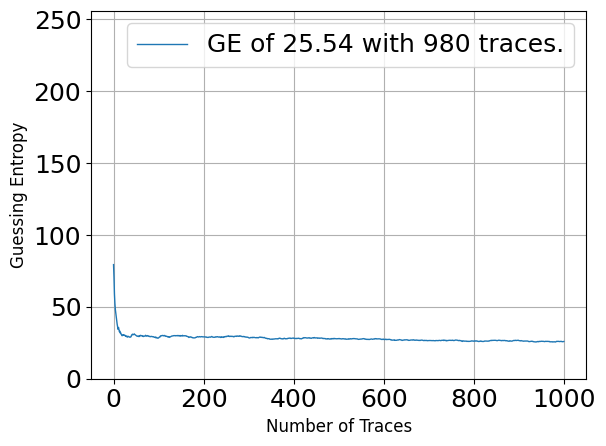

In [15]:
# Common way to show GE convergence in related research papers.
figure = plt.gcf()
plt.rcParams.update({'font.size': 18})
plt.plot(mlp_opoi_avgge, linewidth=1, label=f"GE of {np.min(mlp_opoi_avgge)} with {np.argmin(mlp_opoi_avgge)} traces.")
plt.grid(True, which="both", ls="-")
plt.xlabel("Number of Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

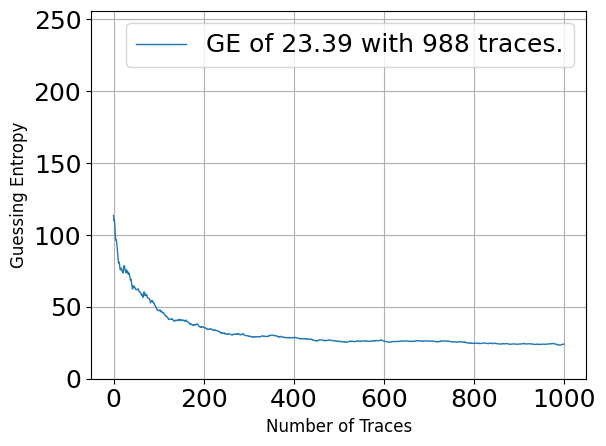

In [18]:
# Common way to show GE convergence in related research papers.
figure = plt.gcf()
plt.rcParams.update({'font.size': 18})
plt.plot(mlp_ascad_avgge, linewidth=1, label=f"GE of {np.min(mlp_ascad_avgge)} with {np.argmin(mlp_ascad_avgge)} traces.")
plt.grid(True, which="both", ls="-")
plt.xlabel("Number of Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

Nous observons que le modèle `best_mlp_id_opoi_1400_ascadr` est plus performant que le modèle `mlp_best` proposé dans le papier initial d'ASCAD.

## 1.2 - Attaque utilisant un CNN

Dans cette section, nous allons utiliser un CNN pour attaquer les traces de la base de données ASCAD et comparer les résultats.

### 1.1.1 - Définition des modèles MLP

Ce modèle a également été présenté en $2022$ par Perin, Guilherme, Lichao Wu, and Stjepan Picek, dans le papier *"Exploring feature selection scenarios for deep learning-based side-channel analysis."*, dans le but d'obtenir le meilleur modèle cnn pour la base de donnée ASCAD.

In [19]:
# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
# https://github.com/AISyLab/feature_selection_dlsca/blob/master/experiments/ASCADr/OPOI/best_models.py
def best_cnn_id_opoi_1400_ascadr(classes, number_of_samples):
    # Best Convolutional Neural Network for ASCAD variable key dataset
    # Number of points-of-interest: 1400
    # Leakage model: ID
    # POI interval: [80945, 82345]
    # Number of parameters: 87632

    batch_size = 300
    tf.random.set_seed(511628)
    model = Sequential(name='best_cnn_id_opoi_ascadv_1400')
    model.add(Conv1D(kernel_size=46, strides=23, filters=8, activation='selu', input_shape=(number_of_samples, 1), padding='same'))
    model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(kernel_size=50, strides=25, filters=16, activation='selu', padding='same'))
    model.add(MaxPool1D(pool_size=6, strides=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(kernel_size=44, strides=22, filters=32, activation='selu', padding='same'))
    model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(200, activation='selu', kernel_initializer='he_uniform'))
    model.add(Dense(classes, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model, batch_size

#### 1.2.2 - Entrainement du modèle

In [20]:
model_cnn_id_opoi, batch_size = best_cnn_id_opoi_1400_ascadr(nb_classes, input_size)
nb_epochs = 100
validation_split = 0.2
history_cnn_id_opoi = model_cnn_id_opoi.fit(x=X_profiling, y=Y_profiling, validation_split=validation_split, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

/Users/gaetan/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0040 - loss: 5.6661 - val_accuracy: 0.0044 - val_loss: 5.5688
Epoch 2/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0043 - loss: 5.5569 - val_accuracy: 0.0040 - val_loss: 5.5564
Epoch 3/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0045 - loss: 5.5484 - val_accuracy: 0.0039 - val_loss: 5.5590
Epoch 4/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0051 - loss: 5.5395 - val_accuracy: 0.0060 - val_loss: 5.5111
Epoch 5/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0065 - loss: 5.4684 - val_accuracy: 0.0063 - val_loss: 5.4521
Epoch 6/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0080 - loss: 5.4124 - val_accuracy: 0.0073 - val_loss: 5.4251
Epoch 7/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0090 - loss: 5.3815 - val_accuracy: 0.0080 - val_loss: 5.4030
Epoch 8/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0094 - loss: 5.3602 - val_accu

In [21]:
predictions_cnn_id_opoi = model_cnn_id_opoi.predict(X_attack)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 533us/step


In [22]:
cnn_id_opoi_median_ge, cnn_id_opoi_avg_ge = guessing_entropy(predictions_cnn_id_opoi, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"[CNN_ID_OPOI] GE using median is {cnn_id_opoi_median_ge}, while using average, GE is {cnn_id_opoi_avg_ge}.")

[CNN_ID_OPOI] GE using median is 0.0, while using average, GE is 0.0.


In [23]:
cnn_id_opoi_medge, cnn_id_opoi_avgge = guessing_entropy_convergence(predictions_cnn_id_opoi, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"[CNN_ID_OPOI] GE of {np.min(cnn_id_opoi_avgge)} with {np.argmin(cnn_id_opoi_avgge)} traces.")

[CNN_ID_OPOI] GE of 0.0 with 321 traces.


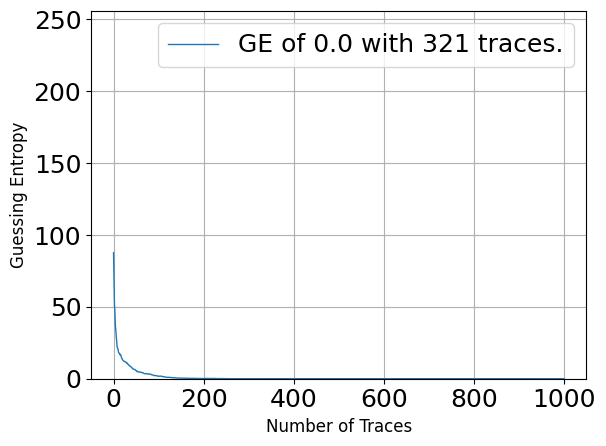

In [24]:
# Common way to show GE convergence in related research papers.
figure = plt.gcf()
plt.rcParams.update({'font.size': 18})
plt.plot(cnn_id_opoi_avgge, linewidth=1, label=f"GE of {np.min(cnn_id_opoi_avgge)} with {np.argmin(cnn_id_opoi_avgge)} traces.")
plt.grid(True, which="both", ls="-")
plt.xlabel("Number of Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

Notre CNN performe extrêmement bien sur la base de données ASCAD, avec seulement 321 traces nécessaires pour retrouver l'octet de la clé.

Dans notre cas, le CNN est le meilleur des trois modèles proposés.

# 2 - Amélioration des modèles

Dans la section précédente, nous avons vu des modèles proposés par les chercheurs. Dans cette partie, nous allons voir les méthodes utilisées par les chercheurs, afin de déterminer quels sont les meilleurs paramètres pour leur modèle, et comment les améliorer.

## 2.1 - Explicabilité

L'explicabilité est de savoir quels sont les points d'intérêt dans la trace qui contribuent à une bonne prédiction dans le réseau de neurones. Une meilleure compréhension de la manière dont les modèles brisent une cible pourrait permettre d'améliorer à l'avenir les méthodes d'attaque ou des mécanismes de défense. C'est donc un aspect important des DLSCA.

Dans cette section, nous allons présenter des techniques de visualisation basique, afin d'illustrer le principe d'explicabilité. Si vous voulez découvrir un peu plus en profondeur l'exlicabilité appliquée aux SCA, voici des papiers intéressants:
- [Gradient visualization for general characterization in profiling attacks](https://doi.org/10.1007/978-3-030-16350-1_9)
- [Deep neural network attribution methods for leakage analysis and symmetric key recovery](https://doi.org/10.1007/978-3-030-38471-5_26)
- [Hide and seek: Using occlusion techniques for side-channel leakage attribution in cnns an evaluation of the ASCAD database](https://doi.org/10.1007/978-3-031-41181-6_8)
- [Occpois: Points of interest based on neural network’s key recovery in side-channel analysis through occlusion](https://eprint.iacr.org/2023/1055)
- [Kilroy was here: The first step towards explainability of neural networks in profiled side-channel analysis](https://doi.org/10.1007/978-3-030-68773-1_9)
- [Peek into the black-box: Interpretable neural network using SAT equations in side-channel analysis](https://doi.org/10.46586/tches.v2023.i2.24-53)
- [Ablation analysis for multi-device deep learning-based physical side-channel analysis](https://doi.org/10.1109/TDSC.2023.3278857)

**Définition \[Signal-to-Noise ratio _(SNR)_]:** Rapport entre le signal et le bruit d'une mesure [(Source)](https://link.springer.com/book/10.1007/978-0-387-38162-6)

Pour faire cela, nous allons utiliser deux fonction:
- `snr_fast`: Permet de calculer le SNR.
- `gradient_vis`: Technique basée sur le gradient utilisant la rétro-propagation pour différencier la perte par rapport à chacun des points d'échantillonnage.

In [26]:
# Function that calculates the Signal-to-Noise ratio (SNR).
def snr_fast(x, y):
    ns = x.shape[1]
    unique = np.unique(y)
    means = np.zeros((len(unique), ns))
    variances = np.zeros((len(unique), ns))

    # For each class compute the mean and the variance at each index of trace
    for i, u in enumerate(unique):
        new_x = x[np.argwhere(y == int(u))]
        means[i] = np.mean(new_x, axis=0)
        variances[i] = np.var(new_x, axis=0)
    return np.var(means, axis=0) / np.mean(variances, axis=0)

<>:51: SyntaxWarning: invalid escape sequence '\o'
<>:54: SyntaxWarning: invalid escape sequence '\o'
<>:55: SyntaxWarning: invalid escape sequence '\o'
<>:51: SyntaxWarning: invalid escape sequence '\o'
<>:54: SyntaxWarning: invalid escape sequence '\o'
<>:55: SyntaxWarning: invalid escape sequence '\o'
/var/folders/wq/x3vp_84133jc_nxh28zg58gh0000gn/T/ipykernel_83326/3687051884.py:51: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(masked_sbox_in_snr/5, label="$p_2 \oplus k_2 \oplus r_{in}$")
/var/folders/wq/x3vp_84133jc_nxh28zg58gh0000gn/T/ipykernel_83326/3687051884.py:54: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(masked_sbox_out_snr, label="$SBox[p_2 \oplus k_2] \oplus r_{out}$")
/var/folders/wq/x3vp_84133jc_nxh28zg58gh0000gn/T/ipykernel_83326/3687051884.py:55: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(masked_sbox_snr, label="$SBox[p_2 \oplus k_2] \oplus r_2$")


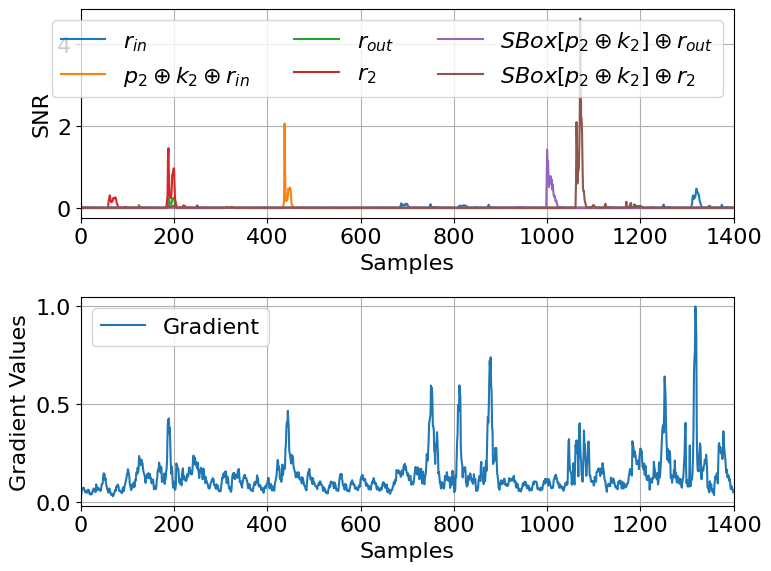

In [27]:
# Finding leakage and input visualization
def gradient_vis(x, y):
  x_tf = tf.Variable(x)
  with tf.GradientTape() as tape:
    tape.watch(x_tf)
    pred = model_cnn_id_opoi(x_tf, training=False)
    loss = tf.keras.losses.CategoricalCrossentropy()(y, pred)

  grads = tape.gradient(loss, x_tf)
  dgrad_abs = tf.math.abs(grads)

  return np.median(dgrad_abs.numpy(), axis=0)

nb_traces_snr_comp = 20000

# Remove final dimension for CNN reshapes
if len(X_attack.shape) > 2:
  X_attack = X_attack[:, :, 0]

#Define intermediate variable shares using masking randomness
masks = attack_metadata["masks"][:, target_byte].astype(np.uint8)
masked_sbox = AES_Sbox[attack_metadata["plaintext"][:, target_byte].astype(np.uint8) ^ attack_metadata["key"][:, target_byte].astype(np.uint8)]^ masks


masks_out = attack_metadata["masks"][:, 17].astype(np.uint8)
masked_sbox_out = AES_Sbox[attack_metadata["plaintext"][:, target_byte].astype(np.uint8) ^ attack_metadata["key"][:, target_byte].astype(np.uint8)]^ masks_out


masks_in = attack_metadata["masks"][:, 16].astype(np.uint8)
masked_sbox_in =attack_metadata["plaintext"][:, target_byte].astype(np.uint8) ^ attack_metadata["key"][:, target_byte].astype(np.uint8)^ masks_in

#Compute Signal-to-Noise ratios for each intermediate value share
mask_snr_out = snr_fast(X_attack[:nb_traces_snr_comp], masks_out[:nb_traces_snr_comp])
masked_sbox_out_snr = snr_fast(X_attack[:nb_traces_snr_comp], masked_sbox_out[:nb_traces_snr_comp])
mask_snr = snr_fast(X_attack[:nb_traces_snr_comp], masks[:nb_traces_snr_comp])
masked_sbox_snr = snr_fast(X_attack[:nb_traces_snr_comp], masked_sbox[:nb_traces_snr_comp])
mask_snr_in = snr_fast(X_attack[:nb_traces_snr_comp], masks_in[:nb_traces_snr_comp])
masked_sbox_in_snr = snr_fast(X_attack[:nb_traces_snr_comp], masked_sbox_in[:nb_traces_snr_comp])

#Compute gradients visualizations for intermediag
if len(Y_attack.shape) == 1:
  grads = gradient_vis(X_attack[:nb_traces_snr_comp], to_categorical(Y_attack[:nb_traces_snr_comp], nb_classes))
else:
  grads = gradient_vis(X_attack[:nb_traces_snr_comp], Y_attack[:nb_traces_snr_comp])

#Plot gradients with SNRs
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(mask_snr_in, label="$r_{in}$")
plt.plot(masked_sbox_in_snr/5, label="$p_2 \oplus k_2 \oplus r_{in}$")
plt.plot(mask_snr_out, label="$r_{out}$")
plt.plot(mask_snr, label="$r_{2}$")
plt.plot(masked_sbox_out_snr, label="$SBox[p_2 \oplus k_2] \oplus r_{out}$")
plt.plot(masked_sbox_snr, label="$SBox[p_2 \oplus k_2] \oplus r_2$")
plt.legend(ncol=3, loc=0)
plt.grid()
plt.ylabel("SNR")
plt.xlim([0,1400])
plt.xlabel("Samples")
plt.subplot(2, 1, 2)
plt.plot(grads/np.max(grads), label="Gradient")
plt.legend(loc=0)
plt.ylabel("Gradient Values")
plt.grid()
plt.xlim([0,1400])
plt.xlabel("Samples")
plt.tight_layout()

plt.show()

Dans l'ensemble, nous pouvons constater que les valeurs de gradient les plus élevées correspondent aux échantillons qui présentent des fuites *(donc les plus intéressants)* dans le graphique SNR. 

Ces tracés peuvent ensuite être utilisés pour déterminer les parts qui contribuent à la fuite exploitée par le modèle et les emplacements correspondants dans la trace où ces parts fuient.

## 2.2 - Recherche des hyperparamètres

La sélection des hyperparamètres est une étape cruciale pour la création d'un bon modèle de deep learning. 

Pour cela, il suffit de tester un grand nombre de paramètres différent sur notre modèle et d'observer quel est la combinaison qui fonctionne le mieux pour notre cas, sans réaliser d'overfitting.

In [28]:
# Download/unzip fixed key variant if it is not downloaded/unzipped already
if os.path.exists("./ASCAD_data.zip") == False:
    !wget https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
    !unzip ASCAD_data.zip

In [29]:
# Load fixed dataset
ascad_dataset = './ASCAD_data/ASCAD_databases/ASCAD.h5'
(X_profiling, Y_profiling), (X_attack, Y_attack), (profiling_metadata, attack_metadata) = load_ascad(ascad_dataset, load_metadata=True)
scaler = StandardScaler()
X_profiling = scaler.fit_transform(X_profiling)
X_attack = scaler.transform(X_attack)
leakage_model = 'ID'
if leakage_model == 'HW':
  nb_classes = 9
elif leakage_model == 'ID':
  nb_classes = 256
if leakage_model == 'HW':
  Y_profiling = calculate_HW(Y_profiling)
  Y_attack = calculate_HW(Y_attack)
Y_profiling= to_categorical(Y_profiling, num_classes=nb_classes)
Y_attack= to_categorical(Y_attack, num_classes=nb_classes)
target_byte=2

In [30]:
# The ranges are taken from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
# Their implementation is available on GitHub https://github.com/AISyLab/feature_selection_dlsca/tree/master
# with more extensive ranges that additionally include regularization methods.
def get_hyperparameters_mlp(max_dense_layers=8):
  return {
      "batch_size": random.randrange(100, 1100, 100),
      "layers": random.randrange(1, max_dense_layers + 1, 1),
      "neurons": random.choice([10, 20, 50, 100, 200, 300, 400, 500]),
      "activation": random.choice(["relu", "selu"]),
      "learning_rate": random.choice([0.005, 0.001, 0.0005, 0.0001]),
      "optimizer": random.choice(["Adam", "RMSprop"]),
      "kernel_initializer": random.choice(["random_uniform", "glorot_uniform", "he_uniform"]),
      "regularization": random.choice(["none"])
  }

def get_hyperparemeters_cnn(max_conv_layers=4, max_dense_layers=4):
    hyperparameters = {}
    hyperparameters_mlp = get_hyperparameters_mlp(max_dense_layers)
    for key, value in hyperparameters_mlp.items():
        hyperparameters[key] = value

    conv_layers = random.choice(range(1, max_conv_layers))
    kernels = []
    strides = []
    filters = []
    pooling_types = []
    pooling_sizes = []
    pooling_strides = []
    pooling_type = random.choice(["Average", "Max"])

    for conv_layer in range(1, conv_layers + 1):
        kernel = random.randrange(26, 52, 2)
        kernels.append(kernel)
        strides.append(int(kernel / 2))
        if conv_layer == 1:
            filters.append(random.choice([4, 8, 12, 16]))
        else:
            filters.append(filters[conv_layer - 2] * 2)
        pool_size = random.choice([2, 4, 6, 8, 10])
        pooling_sizes.append(pool_size)
        pooling_strides.append(pool_size)
        pooling_types.append(pooling_type)

    hyperparameters["conv_layers"] = conv_layers
    hyperparameters["kernels"] = kernels
    hyperparameters["strides"] = strides
    hyperparameters["filters"] = filters
    hyperparameters["pooling_sizes"] = pooling_sizes
    hyperparameters["pooling_strides"] = pooling_strides
    hyperparameters["pooling_types"] = pooling_types
    return hyperparameters


def get_optimizer(optimizer, learning_rate):
    module_name = importlib.import_module("tensorflow.keras.optimizers")
    optimizer_class = getattr(module_name, optimizer)
    return optimizer_class(learning_rate=learning_rate)


# Function that uses the random hyperparameters or those given as an argument to create an MLP model.
def mlp_random(classes, input_size, hp=None):
    hp = get_hyperparameters_mlp() if hp is None else hp

    inputs = Input(shape=(input_size, ))

    x = None
    for layer_index in range(hp["layers"]):
        x = Dense(hp["neurons"], activation=hp["activation"], kernel_initializer=hp["kernel_initializer"],
                      name='dense_{}'.format(layer_index))(inputs if layer_index == 0 else x)

    outputs = Dense(classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='random_mlp')
    optimizer = get_optimizer(hp["optimizer"], hp["learning_rate"])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model, hp

# Function that uses the random hyperparameters or those given as an argument to create a CNN model.
def cnn_random(classes, input_size, hp=None):
  hp = get_hyperparemeters_cnn() if hp is None else hp

  inputs = Input(shape=(input_size, 1))

  x = None
  for layer_index in range(hp["conv_layers"]):
      x = Conv1D(kernel_size=hp["kernels"][layer_index], strides=hp["strides"][layer_index], filters=hp["filters"][layer_index],
                  activation=hp["activation"], padding="same")(inputs if layer_index == 0 else x)
      if hp["pooling_types"][layer_index] == "average":
          x = AveragePooling1D(pool_size=hp["pooling_sizes"][layer_index], strides=hp["pooling_strides"][layer_index], padding="same")(x)
      else:
          x = MaxPooling1D(pool_size=hp["pooling_sizes"][layer_index], strides=hp["pooling_strides"][layer_index], padding="same")(x)
      x = BatchNormalization()(x)
  x = Flatten()(x)

  for layer_index in range(hp["layers"]):
      x = Dense(hp["neurons"], activation=hp["activation"], kernel_initializer=hp["kernel_initializer"],
                    name='dense_{}'.format(layer_index))(x)

  outputs = Dense(classes, activation='softmax', name='predictions')(x)

  model = Model(inputs, outputs, name='random_cnn')
  optimizer = get_optimizer(hp["optimizer"], hp["learning_rate"])
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model, hp

In [31]:
# setting random seed
seed = 2324411508998340269 #random.randrange(sys.maxsize)
random.seed(seed)
# print('seed random was', seed)
seed = 1434111232 #random.randrange(2**32 - 1)
np.random.seed(seed)
# print('seed np random was', seed)

# The number of epochs per model and number of models can be modified to allow for more models and more extended training for better results.
# Here, we limit these numbers for faster training time and search.
nb_epochs_per_model = 20
nb_prof_traces = 40000
nb_val_traces = 10000
nb_models = 10
avg_ge_list = []
hp_list = []
model_list = []
input_size = len(X_profiling[0])
nb_tr = 40000

# Evaluation is done on the attack set, but for hyperparameter tuning,
# we use a subset of profiling set (validation set) for selecting the best model from the random search
X_val = X_profiling[nb_prof_traces:nb_prof_traces+nb_val_traces]
validation_pt = profiling_metadata["plaintext"][nb_prof_traces:nb_prof_traces+nb_val_traces, target_byte]
correct_key_val = profiling_metadata["key"][nb_tr, target_byte]
for i in range(nb_models):
    model, hp = mlp_random(classes=nb_classes, input_size=input_size)
    model.fit(x=X_profiling[:nb_prof_traces], y=Y_profiling[:nb_prof_traces], batch_size=hp["batch_size"], verbose=0, epochs=nb_epochs_per_model, shuffle=True)
    predictions = model.predict(X_val)
    ge_median, ge_avg = guessing_entropy(predictions, validation_pt, correct_key_val, 200)
    avg_ge_list.append(ge_avg)
    model_list.append(model.get_weights())
    print(f"Model {i} has GE {ge_avg}")
    hp_list.append(hp)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
Model 0 has GE 135.99
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
Model 1 has GE 7.68
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
Model 2 has GE 6.2
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
Model 3 has GE 2.43
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
Model 4 has GE 16.99
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
Model 5 has GE 31.22
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Model 6 has GE 9.58
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
Model 7 has GE 136.55
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 8 has GE 104.28
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
Model 9 has GE 8.19


In [32]:
index_best_hp = np.argmin(avg_ge_list)
best_hp = hp_list[index_best_hp]
print(f"Best GE is {avg_ge_list[index_best_hp]} with the hyperparameters {best_hp}.")
# We train the best hp again with more epochs.
nb_epochs = 50
batch_size = hp["batch_size"]
model, hp = mlp_random(classes=nb_classes, input_size=input_size, hp=best_hp)
history = model.fit(x=X_profiling, y=Y_profiling, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

Best GE is 2.43 with the hyperparameters {'batch_size': 900, 'layers': 5, 'neurons': 200, 'activation': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'kernel_initializer': 'random_uniform', 'regularization': 'none'}.
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0036 - loss: 5.5453
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0042 - loss: 5.5440
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0050 - loss: 5.5430
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0050 - loss: 5.5416
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0046 - loss: 5.5404
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0048 - loss: 5.5388
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0049 - loss: 5.5337
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0068 - loss: 5.4998
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0070 - loss: 5.4469
Epoch 10/50
84/84 ━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
GE of 0.01 with 956 traces.


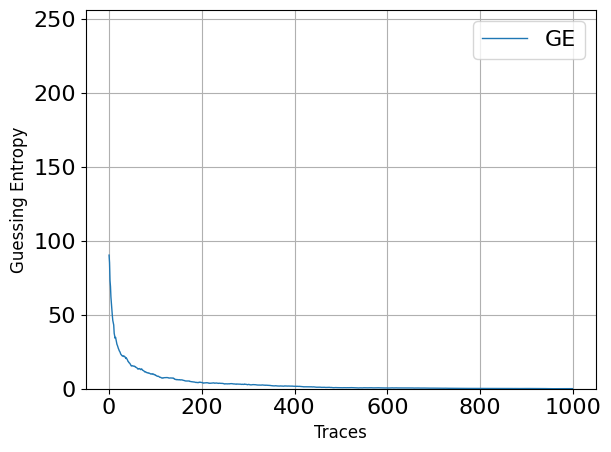

In [33]:
# Evaluation of the best model found with random search hyperparameter tuning.
predictions = model.predict(X_attack)
correct_key = attack_metadata["key"][0, target_byte]
medge, avgge = guessing_entropy_convergence(predictions, attack_metadata["plaintext"][:, target_byte], correct_key, 1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
figure = plt.gcf()
plt.plot(avgge, linewidth=1, label="GE")
plt.grid(True, which="both", ls="-")
plt.xlabel("Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

Nous pouvons conclure que notre meilleur modèle est le **modèle $3$**, avec un **GE** égal à $2.43$.

Les hyperparamètres sont les suivants:

In [36]:
model.summary()

Model: "random_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 256)            │        51,456 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057,370 (4.03 MB)

 Trainable params: 352,456 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704,914 (2.69 MB)

## 2.3 - Méthodes d'ensemble

La méthode d'ensemble est une technique combinant plusieurs algorithmes d'apprentissage pour obtenir de meilleurs résultats prédictifs.

Dans le code ci-dessous, nous allons combiner $5$ modèles.

2.43
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
6.2
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
7.68
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
8.19
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
9.58
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
GE of 0.0 with 917 traces.


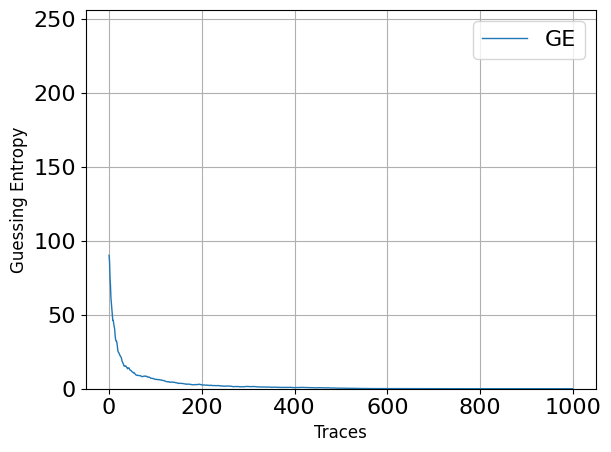

In [37]:
# The number of models to use for the ensemble
nb_models_ensemble = 5

# Sort model indices based on GE
sorted_model_indices = np.argsort(avg_ge_list)

# Take predictions from top N models
predictions_tot = np.zeros((X_attack.shape[0], nb_classes))

for i in range(nb_models_ensemble):
  model_num = sorted_model_indices[i]
  print(avg_ge_list[model_num])
  # Recreate model based on hyperparameters
  hp = hp_list[model_num]
  model, _ = mlp_random(classes=nb_classes, input_size=input_size, hp=hp)

  # Restore trained weights
  model.set_weights(model_list[model_num])

  # Add to total predictions
  predictions_tot += model.predict(X_attack)


predictions_tot /= nb_models_ensemble
corect_key = attack_metadata["key"][0, target_byte]
medge, avgge = guessing_entropy_convergence(predictions_tot, attack_metadata["plaintext"][:, target_byte], correct_key, 1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
figure = plt.gcf()
plt.plot(avgge, linewidth=1, label="GE")
plt.grid(True, which="both", ls="-")
plt.xlabel("Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

Nous observons, qu'avec $5$ modèles en commun, nous avons un $GE$ de $917$.